In [ ]:
#What is the date range?
#Is it household leve or more granular?
#Change timestamp to datetime format in excel
#Group data on user/date?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import psycopg2
import sqlite3
import re
from functools import partial

#regex funcs
def reg_ex_replace(df):
    return re.sub('[!#?]','',df)

def clean_strings(strings, ops):

    result = []
    for value in strings:
        for function in ops:
            value = function(value)
        result.append(value)
    return result

def apply_to_list(some_list, f):
    return [f(x) for x in some_list]


ModuleNotFoundError: No module named 'psycopg2'

In [12]:
#set csv file
csv_file = 'siview_sessions.csv'

In [13]:
#read in df from csv
sessions_data = pd.read_csv(csv_file).drop_duplicates()

In [14]:
sessions_data['id'] = range(1, len(sessions_data) + 1)
sessions_data = sessions_data.reset_index(drop=True)

In [15]:
sessions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158000 entries, 0 to 157999
Data columns (total 24 columns):
account_id              158000 non-null int64
account_source          158000 non-null object
device_id               158000 non-null object
device_mobile           107588 non-null object
device_pc               50412 non-null object
did_pause               158000 non-null bool
household_income        158000 non-null object
is_new_series           158000 non-null bool
isp_id                  158000 non-null object
logged_in_user_age      158000 non-null int64
genre                   158000 non-null object
logged_in_user_idx      158000 non-null int64
num_users_on_account    158000 non-null int64
original_content        158000 non-null bool
product_sku             158000 non-null object
region                  158000 non-null object
session_date            158000 non-null object
session_duration        158000 non-null float64
session_id              158000 non-null object
show  

In [16]:
sessions_data.head(10)

,account_id,account_source,device_id,device_mobile,device_pc,did_pause,household_income,is_new_series,isp_id,logged_in_user_age,...,product_sku,region,session_date,session_duration,session_id,show,skipped_commercials,tenure_in_months,ts,id
0,14601,digital,JLYWJjNGbXbrQPTLefETMcFVeaBIpVYj,NaN,Chrome Windows 10,False,$0-25K,True,CenturyLink,25,...,FAMILY-REG,US West North Central,5/12/19,103.267358,198048cc-2d21-4f5e-9913-c3ed1b5ec54c,Dark,no,13+ months,2019-05-12 00:00:00,1
1,15443,free_trial,fPdZnZvi2YP6rkHmt2mwCgi8pzp2VR2M,NaN,Firefox MacOS,True,$200K+,False,CenturyLink,28,...,FAMILY-HD,US West South Central,5/27/19,67.109324,297f9b6b-d6c5-46e6-a922-a1ba4c3d258c,Go! Live Your Way,no,13+ months,2019-05-27 00:00:00,2
2,10921,digital,rxp3oc5xdaq5zAoD1BK90hfuyliGI4Gg,iPhone 8,NaN,False,$51-100K,True,Verizon Fios,27,...,INDIVIDUAL-REG,US East North Central,5/27/19,47.835372,3babdf05-f1ef-4363-953f-71214748c648,The InBESTigators,occasionally,3-7 months,2019-05-27 00:00:00,3
3,16627,in_store,EWmMmvL7xejwv0yuiHSYcQ9aUzvwYNSL,iPhone X,NaN,True,$51-100K,True,AT&T Internet,32,...,INDIVIDUAL-REG,US East South Central,6/1/19,65.713742,ea8c1d8f-150d-4506-a3c1-0d85af6d23f6,Sacred Games,frequently,13+ months,2019-06-01 00:00:00,4
4,8473,digital,nOBQ3LBa9l25bOH9OtLpSfDgfgE2AdGy,iPhone 8,NaN,False,$51-100K,True,Verizon Fios,29,...,INDIVIDUAL-REG,US West North Central,5/23/19,27.469184,e651630b-8766-46ae-a3fa-25f35d05c9ef,Sacred Games,frequently,0-2 months,2019-05-23 00:00:00,5
5,19882,digital,h8B3fZKjD3nlU21q7fp0I2pjvWgbxzO5,iPhone X,NaN,True,$26-50K,True,Exede Internet,25,...,FAMILY-HD,US South Atlantic,5/28/19,31.986142,cb669920-3839-43fa-af48-4e52e06702fd,Derry Girls,frequently,8-12 months,2019-05-28 00:00:00,6
6,14972,in_store,rGsolvsXh4FPNVFC6iYh3BCiOzhxGLQ2,NaN,Firefox MacOS,True,$0-25K,False,AT&T Internet,28,...,FAMILY-HD-PLUS,US Mid-Atlantic,5/19/19,53.420720,0b6a05b2-9eba-4ab0-98ce-b016a74931c3,Dollar,no,0-2 months,2019-05-19 00:00:00,7
7,18498,digital,MZ7sspC8Y681XWH1i8LuMjhTN02o7QnQ,iPhone 8,NaN,True,$200K+,True,Frontier,29,...,FAMILY-HD,US Mountain,5/6/19,112.105987,3b4a29ef-8943-46f0-8015-eb3de2b3fb00,Diagnosis,occasionally,3-7 months,2019-05-06 00:00:00,8
8,3093,free_trial,yEgcXZvTELn3x1SetdyaiGdi0fswZN6J,iPhone X,NaN,False,$26-50K,True,Comcast Xfinity,28,...,FAMILY-REG,US Mid-Atlantic,5/28/19,65.965068,79e87159-42b1-4e70-88bd-1b0f643985f1,Happy Jail,frequently,3-7 months,2019-05-28 00:00:00,9
9,18324,in_store,MGi9vacu0PWTusnQICMjMWM486xJPKOE,iPhone SE,NaN,True,$51-100K,True,AT&T Internet,21,...,INDIVIDUAL-HD,US Mid-Atlantic,5/25/19,80.429413,b1537e70-6958-406d-87fa-925883b94573,13 Reasons Why: Beyond the Reasons,frequently,8-12 months,2019-05-25 00:00:00,10


In [17]:
#highest sessions desc
display(sessions_data.sort_values(by=['session_duration'],ascending=False))

,account_id,account_source,device_id,device_mobile,device_pc,did_pause,household_income,is_new_series,isp_id,logged_in_user_age,...,product_sku,region,session_date,session_duration,session_id,show,skipped_commercials,tenure_in_months,ts,id
157121,8417,affiliate,i3HIIUy4hBWvTeocZ3OObIGILz7ROpAc,iPhone 6 Plus,NaN,False,$150-200K,False,AT&T Internet,39,...,INDIVIDUAL-HD,US Mid-Atlantic,7/3/19,235.672757,c2ba634c-825f-449d-adc7-f98b35949b1b,The Worst Witch,frequently,0-2 months,2019-07-03 00:00:00,157122
50521,13925,free_trial,F1SB8HCNDovYhxNSXqgUVPVJOp5hDGe2,iPhone X,NaN,False,$101-150K,False,Comcast Xfinity,37,...,INDIVIDUAL-REG,Canada,6/11/19,233.015239,1bf91f48-392e-401c-9743-ae9a79b5b04e,The Worst Witch,occasionally,0-2 months,2019-06-11 00:00:00,50522
31631,5105,affiliate,hqldY2v7gRp8Jghf3HXUUHoJFBMoLBeS,iPhone 6S,NaN,False,$0-25K,False,Exede Internet,40,...,INDIVIDUAL-HD,US East North Central,5/27/19,223.668389,33001728-4ba1-40f7-a0da-488713a6f5f4,Dollar,no,8-12 months,2019-05-27 00:00:00,31632
133082,9852,digital,90Xa5SG8LnwQkcTz7atEVQUPWr6XB9Dy,iPhone SE,NaN,False,$200K+,False,Cox Communications,31,...,FAMILY-REG,US Mid-Atlantic,6/6/19,222.065820,17d4dd69-59cb-4199-88ce-37055d54b4ad,The Mechanism,occasionally,0-2 months,2019-06-06 00:00:00,133083
39137,4131,in_store,NoHmf3kgojHPF4jmQ1drbqxURtORQv6D,NaN,Chrome MacOS,False,$101-150K,True,Mediacom,35,...,INDIVIDUAL-HD-PLUS,US West South Central,6/5/19,221.885845,f218cb70-7317-45b1-b3f1-dddd6d773809,Stranger Things,occasionally,8-12 months,2019-06-05 00:00:00,39138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29322,10784,affiliate,guh2yO7IHHzEHqEZRG4s9OjgxjlUMGuR,iPhone SE,NaN,True,$101-150K,False,Cable ONE,34,...,INDIVIDUAL-HD-PLUS,US New England,6/2/19,0.000000,1f438fdb-f538-40b6-a312-d7155ee2ee01,Black Mirror,occasionally,13+ months,2019-06-02 00:00:00,29323
139942,7727,digital,tNymhNqXCbFYdfn2kuKBGD50aRzvVF7Y,iPhone 7,NaN,False,$51-100K,False,Sprint,28,...,INDIVIDUAL-HD,US West South Central,6/20/19,0.000000,2593618b-dd42-4e9c-9bf4-0f9c138be53e,La casa de papel,frequently,13+ months,2019-06-20 00:00:00,139943
86815,737,in_store,I7J96lyenEJ9CnUkiL7AQQu1yIjcQyqP,iPhone 7,NaN,False,$101-150K,True,Exede Internet,37,...,FAMILY-HD,US Pacific,7/10/19,0.000000,7421248b-f271-4488-aa1c-3bbb151441ff,Quicksand,occasionally,8-12 months,2019-07-10 00:00:00,86816
139915,19443,affiliate,7G40uEN9O1e7P5XBrm1MlEGkfRgm2Kz3,iPhone X,NaN,True,$0-25K,False,Verizon Fios,34,...,FAMILY-REG,US New England,6/7/19,0.000000,c6fde43a-50c1-4742-b891-ce17781652a9,Trailer Park Boys: The Animated Series,occasionally,13+ months,2019-06-07 00:00:00,139916


In [18]:
#reg ex replace
#sessions_data['psychRegions'] = sessions_data['psychRegions'].replace(to_replace='Friendly', value='Angry',regex=True)

In [19]:
#summary stats
sessions_data.describe()

,account_id,logged_in_user_age,logged_in_user_idx,num_users_on_account,session_duration,id
count,158000.000000,158000.000000,158000.000000,158000.000000,158000.000000,158000.000000
mean,10006.570025,30.141013,1.952835,2.018772,52.231851,79000.500000
std,5782.199992,4.296215,1.075591,1.062953,42.541157,45610.815603
min,0.000000,18.000000,1.000000,1.000000,0.000000,1.000000
25%,4980.750000,27.000000,1.000000,1.000000,18.283089,39500.750000
50%,9998.000000,30.000000,2.000000,2.000000,41.496847,79000.500000
75%,15030.000000,33.000000,2.000000,3.000000,78.057037,118500.250000
max,19999.000000,52.000000,5.000000,5.000000,235.672757,158000.000000


In [20]:
#Adding date trunc fields
conn = sqlite3.connect("Temp.db") 
sessions_data.to_sql('sessions_data', conn, if_exists='replace')

statements = ['drop table if exists sessions_dated',
'create table sessions_dated as \
select \
t1.*,\
strftime("%Y-%m-%d", t1.ts) as date, \
strftime("%m", t1.ts) as month, \
strftime("%d", t1.ts) as day, \
strftime("%A", t1.ts) as weekday \
from \
sessions_data as t1']

for statement in statements:
    conn.execute(statement) 

sessions_dated = pd.read_sql('select * from sessions_dated', conn)

In [50]:
#Adding date trunc fields
conn = sqlite3.connect("Temp.db") 
sessions_dated.to_sql('sessions_dated', conn, if_exists='replace')

statements = ['drop table if exists user_counts_time',
'create table user_counts_time as \
select \
t1.date, count(distinct t1.account_id) as user_count \
from \
sessions_dated as t1 \
group by t1.date']

for statement in statements:
    conn.execufte(statement) 

user_counts_time = pd.read_sql('select * from user_counts_time', conn)

In [21]:
sessions_dated.head(10)

,index,account_id,account_source,device_id,device_mobile,device_pc,did_pause,household_income,is_new_series,isp_id,...,session_id,show,skipped_commercials,tenure_in_months,ts,id,date,month,day,weekday
0,0,14601,digital,JLYWJjNGbXbrQPTLefETMcFVeaBIpVYj,None,Chrome Windows 10,0,$0-25K,1,CenturyLink,...,198048cc-2d21-4f5e-9913-c3ed1b5ec54c,Dark,no,13+ months,2019-05-12 00:00:00,1,2019-05-12,05,12,None
1,1,15443,free_trial,fPdZnZvi2YP6rkHmt2mwCgi8pzp2VR2M,None,Firefox MacOS,1,$200K+,0,CenturyLink,...,297f9b6b-d6c5-46e6-a922-a1ba4c3d258c,Go! Live Your Way,no,13+ months,2019-05-27 00:00:00,2,2019-05-27,05,27,None
2,2,10921,digital,rxp3oc5xdaq5zAoD1BK90hfuyliGI4Gg,iPhone 8,None,0,$51-100K,1,Verizon Fios,...,3babdf05-f1ef-4363-953f-71214748c648,The InBESTigators,occasionally,3-7 months,2019-05-27 00:00:00,3,2019-05-27,05,27,None
3,3,16627,in_store,EWmMmvL7xejwv0yuiHSYcQ9aUzvwYNSL,iPhone X,None,1,$51-100K,1,AT&T Internet,...,ea8c1d8f-150d-4506-a3c1-0d85af6d23f6,Sacred Games,frequently,13+ months,2019-06-01 00:00:00,4,2019-06-01,06,01,None
4,4,8473,digital,nOBQ3LBa9l25bOH9OtLpSfDgfgE2AdGy,iPhone 8,None,0,$51-100K,1,Verizon Fios,...,e651630b-8766-46ae-a3fa-25f35d05c9ef,Sacred Games,frequently,0-2 months,2019-05-23 00:00:00,5,2019-05-23,05,23,None
5,5,19882,digital,h8B3fZKjD3nlU21q7fp0I2pjvWgbxzO5,iPhone X,None,1,$26-50K,1,Exede Internet,...,cb669920-3839-43fa-af48-4e52e06702fd,Derry Girls,frequently,8-12 months,2019-05-28 00:00:00,6,2019-05-28,05,28,None
6,6,14972,in_store,rGsolvsXh4FPNVFC6iYh3BCiOzhxGLQ2,None,Firefox MacOS,1,$0-25K,0,AT&T Internet,...,0b6a05b2-9eba-4ab0-98ce-b016a74931c3,Dollar,no,0-2 months,2019-05-19 00:00:00,7,2019-05-19,05,19,None
7,7,18498,digital,MZ7sspC8Y681XWH1i8LuMjhTN02o7QnQ,iPhone 8,None,1,$200K+,1,Frontier,...,3b4a29ef-8943-46f0-8015-eb3de2b3fb00,Diagnosis,occasionally,3-7 months,2019-05-06 00:00:00,8,2019-05-06,05,06,None
8,8,3093,free_trial,yEgcXZvTELn3x1SetdyaiGdi0fswZN6J,iPhone X,None,0,$26-50K,1,Comcast Xfinity,...,79e87159-42b1-4e70-88bd-1b0f643985f1,Happy Jail,frequently,3-7 months,2019-05-28 00:00:00,9,2019-05-28,05,28,None
9,9,18324,in_store,MGi9vacu0PWTusnQICMjMWM486xJPKOE,iPhone SE,None,1,$51-100K,1,AT&T Internet,...,b1537e70-6958-406d-87fa-925883b94573,13 Reasons Why: Beyond the Reasons,frequently,8-12 months,2019-05-25 00:00:00,10,2019-05-25,05,25,None


In [25]:
#pandas df aggs
genre_groupby = sessions_dated.groupby('genre').agg(
    max_session_length=pd.NamedAgg(column='session_duration', aggfunc=max),
    min_session_length=pd.NamedAgg(column='session_duration', aggfunc=min),
    avg_session_length=pd.NamedAgg(column='session_duration', aggfunc=np.mean))


In [68]:
#pandas df aggs
user_age = sessions_dated.groupby('logged_in_user_age').agg(
    max_session_length=pd.NamedAgg(column='session_duration', aggfunc=max),
    min_session_length=pd.NamedAgg(column='session_duration', aggfunc=min),
    avg_session_length=pd.NamedAgg(column='session_duration', aggfunc=np.mean))


In [89]:
#pandas df aggs
users_account = sessions_dated.groupby('num_users_on_account').agg(
    max_session_length=pd.NamedAgg(column='session_duration', aggfunc=max),
    min_session_length=pd.NamedAgg(column='session_duration', aggfunc=min),
    avg_session_length=pd.NamedAgg(column='session_duration', aggfunc=np.mean))


In [90]:
users_account.head()

,max_session_length,min_session_length,avg_session_length
num_users_on_account,,,
1,235.672757,0.0,52.120163
2,221.885845,0.0,52.312243
3,223.668389,0.0,52.314193
4,211.220620,0.0,52.359068
5,200.425985,0.0,52.062150


In [26]:
genre_groupby.head()

,max_session_length,min_session_length,avg_session_length
genre,,,
comedy,233.015239,0.0,52.263963
cooking,209.091835,0.0,51.553756
drama,222.065820,0.0,52.515673
scifi,235.672757,0.0,51.900181
sports,210.334754,0.0,52.632301


In [60]:
#pandas df aggs
hi_groupby = sessions_dated.groupby('household_income').agg(
    max_session_length=pd.NamedAgg(column='session_duration', aggfunc=max),
    min_session_length=pd.NamedAgg(column='session_duration', aggfunc=min),
    avg_session_length=pd.NamedAgg(column='session_duration', aggfunc=np.mean))


In [61]:
hi_groupby.head(10)

,max_session_length,min_session_length,avg_session_length
household_income,,,
$0-25K,223.668389,0.0,52.158374
$101-150K,233.015239,0.0,52.702338
$150-200K,235.672757,0.0,51.970868
$200K+,222.065820,0.0,52.420248
$26-50K,211.402859,0.0,52.061459
$51-100K,221.401085,0.0,52.083658


In [ ]:
#pandas df aggs
users_groupby = sessions_dated.groupby('date').agg(
    number_of_users=pd.NamedAgg(column='user_count', aggfunc=max),)

In [27]:
#pandas df aggs
as_groupby = sessions_dated.groupby('account_source').agg(
    max_session_length=pd.NamedAgg(column='session_duration', aggfunc=max),
    min_session_length=pd.NamedAgg(column='session_duration', aggfunc=min),
    avg_session_length=pd.NamedAgg(column='session_duration', aggfunc=np.mean))


In [28]:
as_groupby.head()

,max_session_length,min_session_length,avg_session_length
account_source,,,
affiliate,235.672757,0.0,51.933115
digital,222.065820,0.0,52.095531
free_trial,233.015239,0.0,52.321346
in_store,221.885845,0.0,52.397544


In [63]:
#pandas df aggs
region_groupby = sessions_dated.groupby('region').agg(
    max_session_length=pd.NamedAgg(column='session_duration', aggfunc=max),
    min_session_length=pd.NamedAgg(column='session_duration', aggfunc=min),
    avg_session_length=pd.NamedAgg(column='session_duration', aggfunc=np.mean))


In [ ]:
geo_groupby.plot(kind='bar',x='geo_field',y='avg_session_length',color='blue')

In [53]:
#dedupe to HH-level 
#sessions aggregates (min, max, avg) over time

sessions_dated.to_sql('sessions_dated', conn, if_exists='replace')

sql = ['drop table if exists user_agg',
'drop table if exists sessions_user_agg',
'create table user_agg as \
SELECT account_id, \
sum(session_duration) as total_seconds_watched, \
avg(session_duration) as avg_session_length, \
min(session_duration) as min_session_length, \
max(session_duration) as max_session_length, \
min(date) as first_watched_any, \
max(date) as last_watched_any, \
(min(date) - max(date)) as user_tenure_days \
FROM sessions_dated \
group by account_id',
'create table sessions_user_agg as \
SELECT \
*\
FROM sessions_dated as t1 \
join user_agg as t2 on t1.account_id=t2.account_id']

for statement in sql:
    conn.execute(statement) 

sessions_user_agg = pd.read_sql('select * from sessions_user_agg', conn)
user_agg = pd.read_sql('select * from user_agg', conn) 


In [70]:
#dedupe to HH-level 
#sessions aggregates (min, max, avg) over time

sessions_dated.to_sql('sessions_dated', conn, if_exists='replace')

sql = [
'create table li_age as \
SELECT logged_in_user_age, \
sum(session_duration) as total_seconds_watched, \
avg(session_duration) as avg_session_length, \
min(session_duration) as min_session_length, \
max(session_duration) as max_session_length, \
min(date) as first_watched_any, \
max(date) as last_watched_any, \
(min(date) - max(date)) as user_tenure_days \
FROM sessions_dated \
group by logged_in_user_age']

for statement in sql:
    conn.execute(statement) 

user_age = pd.read_sql('select * from li_age', conn)


In [41]:
del sessions_user_agg['level_0']

In [33]:
sessions_user_agg.head(10)

,level_0,index,account_id,account_source,device_id,device_mobile,device_pc,did_pause,household_income,is_new_series,...,day,weekday,account_id:1,total_seconds_watched,avg_session_length,min_session_length,max_session_length,first_watched_any,last_watched_any,user_tenure_days
0,0,0,14601,digital,JLYWJjNGbXbrQPTLefETMcFVeaBIpVYj,None,Chrome Windows 10,0,$0-25K,1,...,12,None,14601,398.470903,39.847090,0.301830,122.570466,2019-05-12,2019-07-26,0
1,1,1,15443,free_trial,fPdZnZvi2YP6rkHmt2mwCgi8pzp2VR2M,None,Firefox MacOS,1,$200K+,0,...,27,None,15443,337.108406,67.421681,37.140922,114.714554,2019-05-09,2019-07-06,0
2,2,2,10921,digital,rxp3oc5xdaq5zAoD1BK90hfuyliGI4Gg,iPhone 8,None,0,$51-100K,1,...,27,None,10921,391.488054,43.498673,2.000000,124.423490,2019-05-16,2019-07-22,0
3,3,3,16627,in_store,EWmMmvL7xejwv0yuiHSYcQ9aUzvwYNSL,iPhone X,None,1,$51-100K,1,...,01,None,16627,309.858546,34.428727,0.000000,88.063150,2019-06-01,2019-07-24,0
4,4,4,8473,digital,nOBQ3LBa9l25bOH9OtLpSfDgfgE2AdGy,iPhone 8,None,0,$51-100K,1,...,23,None,8473,571.486127,47.623844,1.000000,139.507087,2019-05-14,2019-07-25,0
5,5,5,19882,digital,h8B3fZKjD3nlU21q7fp0I2pjvWgbxzO5,iPhone X,None,1,$26-50K,1,...,28,None,19882,341.796591,37.977399,0.000000,127.908887,2019-05-15,2019-07-26,0
6,6,6,14972,in_store,rGsolvsXh4FPNVFC6iYh3BCiOzhxGLQ2,None,Firefox MacOS,1,$0-25K,0,...,19,None,14972,474.731273,59.341409,34.805214,97.238324,2019-05-12,2019-07-25,0
7,7,7,18498,digital,MZ7sspC8Y681XWH1i8LuMjhTN02o7QnQ,iPhone 8,None,1,$200K+,1,...,06,None,18498,432.325067,48.036119,5.391483,112.105987,2019-05-06,2019-07-27,0
8,8,8,3093,free_trial,yEgcXZvTELn3x1SetdyaiGdi0fswZN6J,iPhone X,None,0,$26-50K,1,...,28,None,3093,564.349492,62.705499,1.000000,145.695174,2019-05-06,2019-07-24,0
9,9,9,18324,in_store,MGi9vacu0PWTusnQICMjMWM486xJPKOE,iPhone SE,None,1,$51-100K,1,...,25,None,18324,453.797316,56.724664,5.955055,117.417156,2019-05-25,2019-07-09,0


In [ ]:
#calculating aggregates

In [44]:
#aggregate session durations (min, max, avg) over time 

sessions_user_agg.to_sql('sessions_user_agg', conn, if_exists='replace')

sql = ['drop table if exists session_date_agg',
'create table session_date_agg as \
SELECT date, \
sum(session_duration) as total_seconds_watched, \
avg(session_duration) as avg_session_length, \
min(session_duration) as min_session_length, \
max(session_duration) as max_session_length \
FROM sessions_user_agg \
group by date']

for statement in sql:
    conn.execute(statement) 

session_date_agg = pd.read_sql('select * from session_date_agg', conn)
session_date_agg.head(10)

,date,total_seconds_watched,avg_session_length,min_session_length,max_session_length
0,2019-05-06,59141.256365,51.027831,0.0,196.448104
1,2019-05-07,65057.626956,52.213184,0.0,210.483044
2,2019-05-08,62200.475342,50.000382,0.0,201.227094
3,2019-05-09,63362.281295,48.405104,0.0,194.417544
4,2019-05-10,65007.749895,49.852569,0.0,195.380949
5,2019-05-11,60892.525789,50.034943,0.0,186.627958
6,2019-05-12,61684.746487,50.895005,0.0,189.783594
7,2019-05-13,62268.153603,52.150882,0.0,205.490827
8,2019-05-14,58133.944936,48.203934,0.0,177.803032
9,2019-05-15,60881.351837,49.577648,0.0,193.132156


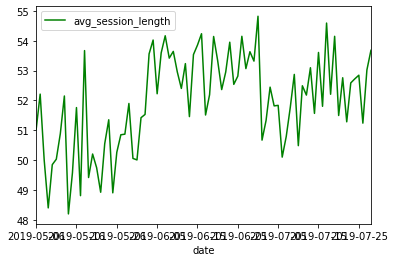

In [45]:
#avg seconds watched
session_date_agg.plot(kind='line',x='date',y='avg_session_length',color='green')

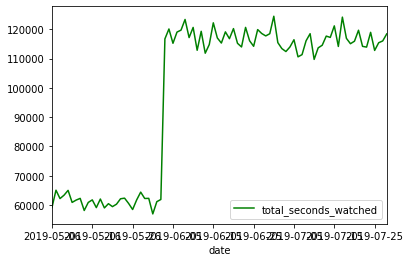

In [46]:
#total seconds watched over time
session_date_agg.plot(kind='line',x='date',y='total_seconds_watched',color='green')

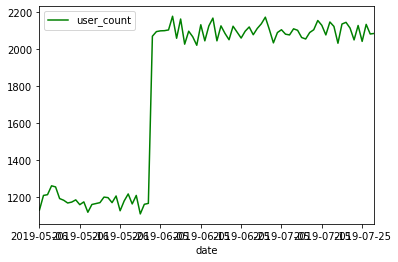

In [65]:
user_counts_time.plot(kind='line',x='date',y='user_count',color='green')

In [64]:
#plot some data from session user agg to reg test
region_groupby.plot(kind='bar',x='region',y='avg_session_length',color='red')

KeyError: 'region'

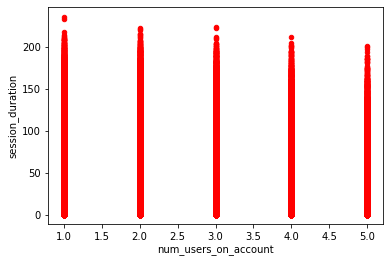

In [77]:
sessions_dated.plot(kind='scatter',x='num_users_on_account',y='session_duration',color='red')

In [91]:
lin_reg = sm.OLS(sessions_dated['session_duration'],sessions_user_agg['logged_in_user_age']).fit()

In [ ]:
lin_reg = sm.OLS(sessions_user_agg['session_duration'],sessions_user_agg['tenure_in_months']).fit()

In [92]:
print(lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:       session_duration   R-squared (uncentered):                   0.593
Model:                            OLS   Adj. R-squared (uncentered):              0.593
Method:                 Least Squares   F-statistic:                          2.301e+05
Date:                Mon, 18 Nov 2019   Prob (F-statistic):                        0.00
Time:                        15:59:35   Log-Likelihood:                     -8.1839e+05
No. Observations:              158000   AIC:                                  1.637e+06
Df Residuals:                  157999   BIC:                                  1.637e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

AttributeError: 'Series' object has no attribute 'session_duration'

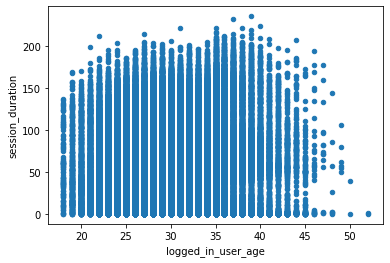

In [95]:
import statsmodels.api as sm

model = sm.OLS(sessions_dated.session_duration, sm.add_constant(sessions_dated.logged_in_user_age))
p = model.fit().params

# x-values for regression line
x = np.arange(1, 80)

ax = sessions_dated.plot(x='logged_in_user_age', y='session_duration', kind='scatter')
ax.plot(x, p.const + p.session_duration * x)
ax.set_xlim([1, 90])

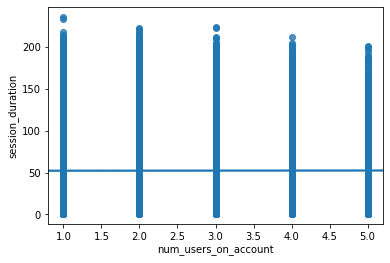

In [88]:
import seaborn as sns
sns.regplot(x='num_users_on_account', y='session_duration', data=sessions_dated)

In [ ]:
#choose regressors based on scatter plots
lin_reg = sm.OLS(session_dated['session_length'],session_dated['total_HH_seconds_watched']).fit()

In [14]:
#one-hot encoding fields

statements = ['drop table if exists rep_ids',
'drop table if exists dem_ids',
'create table rep_ids as select distinct id from state_data where governor="Republican"',
'create table dem_ids as select distinct id from state_data where governor="Democrat"',
'create table state_data_coded as \
select \
t1.*, case when t2.id is null then 0 else 1 end as rep_coded,case when t3.id is null then 0 else 1 end as dem_coded \
from \
state_data as t1 \
left join rep_ids as t2 on t1.id=t2.id \
left join dem_ids as t3 on t1.id=t3.id']

for statement in statements:
    conn.execute(statement)

In [16]:
state_encoded = pd.read_sql('select * from state_data_coded', conn)

In [ ]:
#sql date diffs, date trunc for time series aggs (sum/avg over week, hour, etc)
#lag and window function in pandas dataframe

In [67]:
#pandas add column for cumulative sum
statedata_dates_group_by = statedata_dates.groupby(['ts']).cumsum()

In [68]:
statedata_dates_group_by.head()

,index,extraversion,agreeableness,conscientiousness,neuroticism,openness,instagram,facebook,retweet,entrepreneur,gdpr,privacy,university,mortgage,volunteering,museum,scrapbook,modernDance,units
0,0,55.5,52.7,55.5,48.7,42.7,0.64,1.65,0.35,0.26,-0.77,0.58,1.74,1.41,-1.49,-1.11,0.06,-1.27,2
1,1,106.1,99.3,113.9,86.8,97.4,0.82,1.39,-0.22,0.82,-1.08,0.13,0.97,2.42,-0.53,-1.24,0.40,-0.86,4
2,3,156.0,152.0,154.9,143.0,137.7,1.28,2.49,-0.82,1.07,-1.68,0.82,0.99,1.76,-1.72,-2.19,1.25,-2.30,8
3,6,207.4,201.0,198.1,182.1,202.7,2.75,2.07,-0.34,1.57,-0.56,1.05,-0.93,0.88,-1.15,-2.14,0.56,-1.92,9
4,10,252.7,248.5,256.9,216.4,260.6,1.71,1.01,-1.24,1.59,0.03,0.83,-1.37,2.37,-0.14,-1.42,0.22,-2.21,11
